<a href="https://colab.research.google.com/github/alsindirose-afk/Dal-Shemagh-Challenge-Solution/blob/main/Copy_of_Dal_Shemagh_Object_Detection_Challenge_Rose_Khairoalsendi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© 2026 Rose Abdulqadir Khairoalsendi. All rights reserved.

This material may not be copied, redistributed, modified, or used
without explicit written permission from the author.

In [ ]:
# Author: Rose Abdulqadir Khairoalsendi
# Created: February 2026
# Copyright © 2026 Rose Abdulqadir Khairoalsendi

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import shutil
import random
from PIL import Image

**Splitting The Training Data into Training & Validation Data**

In [ ]:
#Run this code only ONCE EVER, running it everytime ruins the distribution of data

In [ ]:
# @title
import shutil
from sklearn.model_selection import train_test_split

root = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal'
train_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/train'
train_labels_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/train'

train_image_paths = glob.glob(os.path.join(train_images_path, "*.jpg"))

train_images, val_images = train_test_split(train_image_paths, test_size=.3, random_state=42, shuffle=True)

val_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/val'
val_labels_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/val'


for img in val_images:
  img_name = img.split("/")[-1]
  shutil.move(img, val_images_path)


In [ ]:
# @title
val_image_paths = glob.glob(os.path.join(root, 'images', 'val', '*.jpg'))

for img in val_images:
  img_name = img.split('/')[-1].split(".")[0]
  label_path = os.path.join(root, 'labels/train', img_name+'.txt')
  shutil.move(label_path, val_labels_path)

In [ ]:
root = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal'

train_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/train'
train_labels_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/train'

val_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/val'
val_labels_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/val'

all_images_path = "/content/drive/MyDrive/Datasets/images_dal_shemagh"
all_labels_path = "/content/drive/MyDrive/Datasets/labels_dal_shemagh"

**Organizing The Label Files' Contents in Numpy Arrays to Use Later in Classification**

In [ ]:
# @title
# Creating a function to calculate IOU for different boxes

def calculate_iou(vec1, Xmin, Xmax, Ymin, Ymax):
  if Xmin.size == 0 or Xmax.size == 0 or Ymin.size == 0 or Ymax.size == 0:
    return 0

  # vec format: np.array([xmin, ymin, xmax, ymax])
  # iou formula: (min(xmax1, xmax2)-abs(xmin2-xmin1))*(min(ymax1, ymax2)-abs(ymin2-ymin1))/((xmax2-xmin2)*(ymax2-ymin2)+(xmax1-xmin1)*(ymax1-ymin1))
  # w = min(xmax1, xmax2)-max(xmin1, xmin2)
  # h = min(ymax1, ymax2)-max(ymin1, ymin2)

  xmin, ymin, xmax, ymax = vec1[0], vec1[1], vec1[2], vec1[3]

  area = (xmax-xmin)*(ymax-ymin)
  areas = (Xmax-Xmin)*(Ymax-Ymin)

  union = area+areas


  x_condition_max = xmax<Xmax
  y_condition_max = ymax<Ymax
  x_condition_min = xmin>Xmin
  y_condition_min = ymin>Ymin

  x_right = np.zeros_like(Xmin)+Xmax
  y_top = np.zeros_like(Ymin)+Ymax
  x_left = np.zeros_like(Xmax)+Xmin
  y_bottom = np.zeros_like(Ymax)+Ymin

  x_right[Xmax>xmax] = xmax
  y_top[Ymax>ymax] = ymax
  x_left[Xmin<xmin] = xmin
  y_bottom[Ymin<ymin] = ymin

  h = y_top-y_bottom
  h[h<=0] = 0

  w = x_right - x_left
  w[w<=0] = 0

  intersection = h*w
  union -= intersection

  return np.max(intersection/union)



In [ ]:
# @title

train_label_paths = glob.glob(os.path.join(train_labels_path, "*.txt"))
val_label_paths = glob.glob(os.path.join(val_labels_path, "*.txt"))

images_path = "/content/drive/MyDrive/Datasets/images_dal_shemagh"
labels_path = "/content/drive/MyDrive/Datasets/labels_dal_shemagh"

metadata_path = "/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/train_labels.csv"
csv_file = pd.read_csv(metadata_path)

X = []
labels= []

for i, img_name in enumerate(csv_file['filename'].values):
  file_name = img_name.split("/")[-1].split(".")[0]
  label_name = file_name+'.txt'

  '''try:
    label_file = os.path.join(train_labels_path, label_name)
    f = open(label_file, "r")
  except FileNotFoundError:
    label_file = os.path.join(val_labels_path, label_name)
    f = open(label_file, "r")'''
  label_file = os.path.join(labels_path, "train", label_name)


  right_place = csv_file['right_place'].iloc[i]

  f = open(label_file, "r")
  data_lines = f.readlines()
  f.close()

  objects = [] # to store shemaqs and heads found in the labels file
  widths = []
  heights = []
  areas = []


  Xmin_0 = []
  Xmax_0 = []
  Xmin_1 = []
  Xmax_1 = []

  Ymin_0 = []
  Ymax_0 = []
  Ymin_1 = []
  Ymax_1 = []

  max_iou = 0
  min_distance = 640

  if data_lines == []:
    continue

  for i, line in enumerate(data_lines):
    line = line.split(" ")
    line = [float(num) for num in line]

    objects.append(line[0])
    x, y, w, h = line[1], line[2], line[3], line[4]

    xmin, xmax, ymin, ymax = x-w/2, x+w/2, y-h/2, y+h/2
    area = (w)*(h)

    areas.append(area)
    widths.append(w)
    heights.append(h)

    if objects[-1] == 0:
      Xmin_0.append(xmin)
      Xmax_0.append(xmax)
      Ymin_0.append(ymin)
      Ymax_0.append(ymax)
    elif objects[-1] == 1:
      Xmin_1.append(xmin)
      Xmax_1.append(xmax)
      Ymin_1.append(ymin)
      Ymax_1.append(ymax)


    Xmin_0_np = np.array(Xmin_0)
    Xmin_1_np = np.array(Xmin_1)
    Xmax_0_np = np.array(Xmax_0)
    Xmax_1_np = np.array(Xmax_1)
    Ymin_0_np = np.array(Ymin_0)
    Ymin_1_np = np.array(Ymin_1)
    Ymax_0_np = np.array(Ymax_0)
    Ymax_1_np = np.array(Ymax_1)

    boxes_0_min = np.stack((Xmin_0_np, Ymin_0_np), axis=-1)
    boxes_0_max = np.stack((Xmax_0_np, Ymax_0_np), axis=-1)
    boxes_0 = np.stack((boxes_0_min, boxes_0_max), axis=-1)

    boxes_1_min = np.stack((Xmin_1_np, Ymin_1_np), axis=-1)
    boxes_1_max = np.stack((Xmax_1_np, Ymax_1_np), axis=-1)
    boxes_1 = np.stack((boxes_1_min, boxes_1_max), axis=-1)

    vec = np.array([xmin, ymin, xmax, ymax])


    if objects[-1] == 0:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_1_np, Xmax_1_np, Ymin_1_np, Ymax_1_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_1_np+Xmax_1_np)/2)*(x-(Xmin_1_np+Xmax_1_np)/2)))+((y-(Ymin_1_np+Ymax_1_np)/2)*(y-(Ymin_1_np+Ymax_1_np)/2)))
      except ValueError:
        min_found_dist = 640

      min_distance = min(min_distance, min_found_dist)

    elif objects[-1] == 1:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_0_np, Xmax_0_np, Ymin_0_np, Ymax_0_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_0_np+Xmax_0_np)/2)*(x-(Xmin_0_np+Xmax_0_np)/2)))+((y-(Ymin_0_np+Ymax_0_np)/2)*(y-(Ymin_0_np+Ymax_0_np)/2)))
      except ValueError:
        min_found_dist = 640


      min_distance = min(min_distance, min_found_dist)


  has_shemaq = 1 if 1 in objects else 0
  has_head = 1 if 0 in objects else 0
  features = [] # creating a feature vector for this image
  features.append(img_name)
  features.append(has_shemaq)
  features.append(has_head)
  features.append(np.mean(areas))
  features.append(np.mean(heights))
  features.append(np.mean(widths))
  features.append(max_iou)
  features.append(min_distance)


  X.append(features) # appending to full feature vector

  labels.append(0 if right_place==False else 1) # adding label


In [ ]:
# @title
cls_df = pd.DataFrame(X, columns=['img_name', 'has_shemaq','has_head', 'mean_box_area', 'mean_box_height', 'mean_box_width', 'max_iou', 'min_distance'])
cls_df['label'] = labels


**Doing Some Feature Engineering**

In [ ]:
# @title
cls_df['mean_abs_box_diagonal_slope'] = cls_df['mean_box_height']/cls_df['mean_box_width']

In [ ]:
# @title
cls_df.to_csv("binary_classification.csv", index=False)

In [ ]:
# @title
max_iou = max(cls_df['max_iou'])
print(max_iou)
img_name = cls_df[cls_df['max_iou']==max_iou]['img_name']
print(img_name)

0.41146939978675706
266    393.jpg
Name: img_name, dtype: object


**Creating Extra Folders For External Training & Validation (To Implement a Later Idea)**

In [ ]:
# @title
train_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/train'
train_image_paths = glob.glob(os.path.join(train_images_path, "*.jpg"))

val_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/val'
val_image_paths = glob.glob(os.path.join(val_images_path, "*.jpg"))

train_images, train_ext_images = train_test_split(train_image_paths, test_size=.1, random_state=42, shuffle=True)


val_images, val_ext_images = train_test_split(val_image_paths, test_size=.1, random_state=42, shuffle=True)


ext_train_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Training/Images'
ext_train_labels_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Training/Labels'
ext_val_images_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Validation/Images'
ext_val_labels_path = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Validation/Labels'

for img in train_ext_images:
  img_name = img.split("/")[-1]
  new_path = os.path.join(ext_train_images_path, img_name)
  shutil.move(img, new_path)
  img_name = img.split('/')[-1].split(".")[0]
  label_path = os.path.join(root, 'labels/train', img_name+'.txt')
  shutil.move(label_path, ext_train_labels_path)


for img in val_ext_images:
  img_name = img.split("/")[-1]
  new_path = os.path.join(ext_val_images_path, img_name)
  shutil.move(img, new_path)
  img_name = img.split('/')[-1].split(".")[0]
  label_path = os.path.join(root, 'labels/val', img_name+'.txt')
  shutil.move(label_path, ext_val_labels_path)

**Loading The Data & Preparing The data.yaml File**

In [ ]:
# @title
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml

def create_data_yaml(path_to_data_yaml):


  # Create data dictionary
  data = {
      'path': '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal',
      'train': 'images/train',
      'val': 'images/val',
      'test': 'images/test',
      'nc': 2,
      'names': ['Head', 'Shemaq']
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_data_yaml = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml'

create_data_yaml(path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml

File contents:

cat: /content/data.yaml: No such file or directory


In [ ]:
path_to_data_yaml = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml'

**Running a Baseline Model (Yolo8S for Object Detection & XGBoost Classifier with Oversampling & Stratified K-Fold with 10 Folds due to Imbalanced Data)**

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model8s = YOLO("yolov8s.pt")

In [ ]:
# @title
NUM_EPOCHS = 20
IMGSIZE = 640

model8s.train(data=path_to_data_yaml, epochs=NUM_EPOCHS, imgsz=IMGSIZE)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.2, data=/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml, degrees=15, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.007, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f4d594faa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

**Trying The Baseline Model**

In [ ]:
model_baseline = YOLO("/content/yolov8s.pt")

test_images = glob.glob(os.path.join(root, 'images', 'test', "*.jpg"))

results = model_baseline(test_images[38])

results[0].show()

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

**Adjusting The Models & Creating New Ones After Hyperparameter Tuning**

**Model 1: YOLOv8n**

In [ ]:
model8n = YOLO("yolov8n.pt")

In [ ]:
NUM_EPOCHS = 30
IMGSIZE = 640

model8n.train(data=path_to_data_yaml, epochs=NUM_EPOCHS, imgsz=IMGSIZE, lr0=.001, lrf=.01, degrees=15, shear=30, flipud=.3, mixup=.2, cutmix=.2, copy_paste=.5)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.2, data=/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml, degrees=15, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.007, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f4d594faa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Saving the model

model8n.save("yolo8n_baseline_with_augmentations0.pt")

**Model 2: YOLOv9n**

In [ ]:
model9t = YOLO("yolov9t.pt")

In [ ]:
NUM_EPOCHS = 30
IMGSIZE= 640

model9t.train(data=path_to_data_yaml, epochs=NUM_EPOCHS, imgsz=IMGSIZE, lr0=.001, lrf=.005, degrees=20, shear=10, mixup=.2, cutmix=.3, copy_paste=.5, hsv_h=.03, translate=.3, perspective=.0004)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.3, data=/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml, degrees=20, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov9t.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df62015a090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
model9t.save("yolo9t_finetuned.pt")

**Training a Second YOLOv9t Model with lrf = .0025 Based on The Training Results**

In [ ]:
model9t_adjusted = YOLO("yolov9t.pt")

In [ ]:
NUM_EPOCHS = 30
IMGSIZE= 640

model9t.train(data=path_to_data_yaml, epochs=NUM_EPOCHS, imgsz=IMGSIZE, lr0=.001, lrf=.0025, degrees=20, shear=10, mixup=.2, cutmix=.3, copy_paste=.5, hsv_h=.03, translate=.3, perspective=.0004)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.3, data=/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml, degrees=20, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov9t.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df62015a090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
model9t_adjusted.save("yolo9t_adjusted.pt")

**Model 3: YOLOv10n**

In [ ]:
model10n = YOLO("yolo10n.pt")

In [ ]:
NUM_EPOCHS = 30
IMGSIZE = 640

model10n.train(data=path_to_data_yaml, epochs=NUM_EPOCHS, imgsz=IMGSIZE, lr0=.001, lrf=.007, degrees=15, shear=30, flipud=.3, mixup=.2, cutmix=.2, copy_paste=.5)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.2, data=/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml, degrees=15, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.007, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f4d594faa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Saving the model

model10n.save("yolov10n.pt")

**Model 4: YOLOv11n**

In [ ]:
model11n = YOLO("yolo11n.pt")

In [ ]:
NUM_EPOCHS = 30
IMGSIZE = 640

model11n.train(data=path_to_data_yaml, epochs=NUM_EPOCHS, imgsz=IMGSIZE, lr0=.001, lrf=.001, degrees=20, shear=10, mixup=.2, cutmix=.3, copy_paste=.5, hsv_h=.03, translate=.3, perspective=.0004)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=flip, cos_lr=False, cutmix=0.3, data=/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data.yaml, degrees=20, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.03, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9250133800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
model11n.save("yolov11n_finetuned.pt")

**Evaluating The Models**

In [ ]:
model8n = YOLO("/content/yolo8n_baseline_with_augmentations0.pt")

In [ ]:
model8n.val(data=path_to_data_yaml)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 15.4±32.0 ms, read: 17.6±18.5 MB/s, size: 108.8 KB)
val: Scanning /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/val.cache... 176 images, 51 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 33.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 5.0s/it 54.7s
                   all        176        181      0.843      0.705      0.843       0.45
                  Head        104        138      0.883      0.783      0.848      0.478
                Shemaq         40         43      0.802      0.628      0.838      0.422
Speed: 2.0ms preprocess, 287.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/runs/detect/val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f4f8067140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# @title
model9t.val(data=path_to_data_yaml)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv9t summary (fused): 197 layers, 1,971,174 parameters, 0 gradients, 7.6 GFLOPs
val: Fast image access ✅ (ping: 147.9±322.4 ms, read: 3.8±3.4 MB/s, size: 91.2 KB)
val: Scanning /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/val.cache... 176 images, 51 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 30.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 5.9s/it 1:04
                   all        176        181      0.888      0.772      0.846      0.535
                  Head        104        138      0.974      0.754      0.863      0.563
                Shemaq         40         43      0.802      0.791      0.829      0.508
Speed: 2.4ms preprocess, 339.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df627cdec00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
metrics = model10n.val(data=path_to_data_yaml)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv10n summary (fused): 102 layers, 2,265,558 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 2.0±1.4 ms, read: 15.0±5.1 MB/s, size: 91.7 KB)
val: Scanning /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/val.cache... 176 images, 51 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 19.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 4.6s/it 51.1s
                   all        176        181       0.68       0.62      0.689      0.376
                  Head        104        138      0.758      0.681      0.746      0.448
                Shemaq         40         43      0.602      0.558      0.632      0.304
Speed: 2.3ms preprocess, 271.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /content/runs/detect/val


In [ ]:
model11n.val(data=path_to_data_yaml)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 101 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 46.2±15.4 MB/s, size: 91.2 KB)
val: Scanning /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/labels/val.cache... 176 images, 51 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 30.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 5.7s/it 1:03
                   all        176        181       0.85      0.787      0.838      0.513
                  Head        104        138      0.965      0.761       0.87      0.584
                Shemaq         40         43      0.734      0.814      0.806      0.441
Speed: 2.9ms preprocess, 333.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9270501ac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

**Testing The Models**


image 1/1 /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/test/242.jpg: 640x640 (no detections), 394.1ms
Speed: 3.7ms preprocess, 394.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


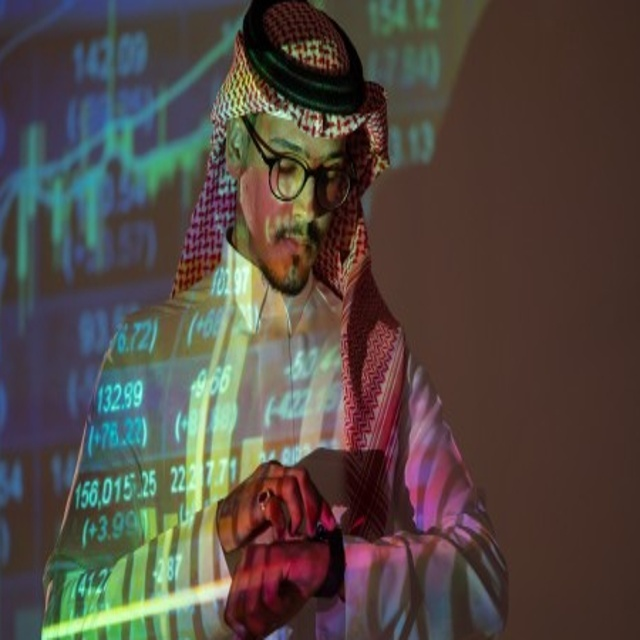

In [ ]:
test_images = glob.glob(os.path.join(root, 'images', 'test', "*.jpg"))

results = model8n(test_images[8])

results[0].show()


image 1/1 /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/test/305.jpg: 640x640 1 Head, 1 Shemaq, 240.9ms
Speed: 2.6ms preprocess, 240.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


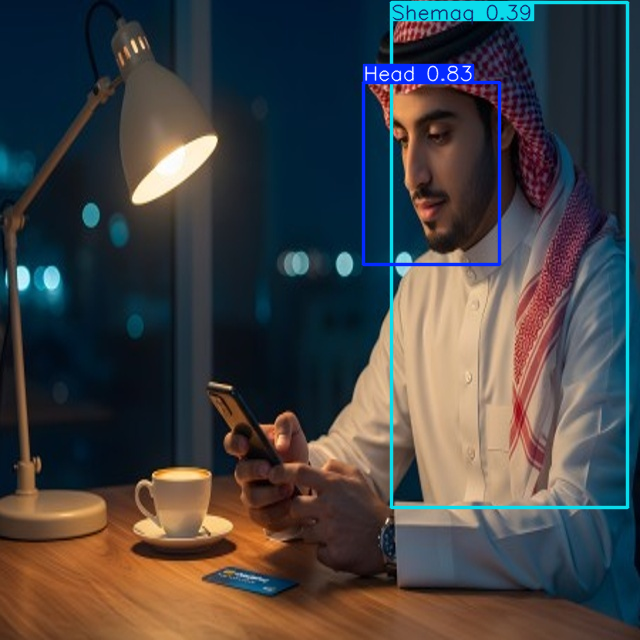

In [ ]:
model9t = YOLO("/content/yolo9t_finetuned.pt")
test_images = glob.glob(os.path.join(root, 'images', 'test', "*.jpg"))
random_idx = random.sample(range(len(test_images)), 1)[0]
results = model9t(test_images[random_idx])

results[0].show()

In [ ]:
test_images = glob.glob(os.path.join(root, 'images', 'test', "*.jpg"))

results = model10n(test_images[38])

results[0].show()

NameError: name 'model10n' is not defined

In [ ]:
model11n = YOLO("/content/yolov11n_finetuned.pt")


image 1/1 /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/images/test/258.jpg: 640x640 (no detections), 194.4ms
Speed: 2.8ms preprocess, 194.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


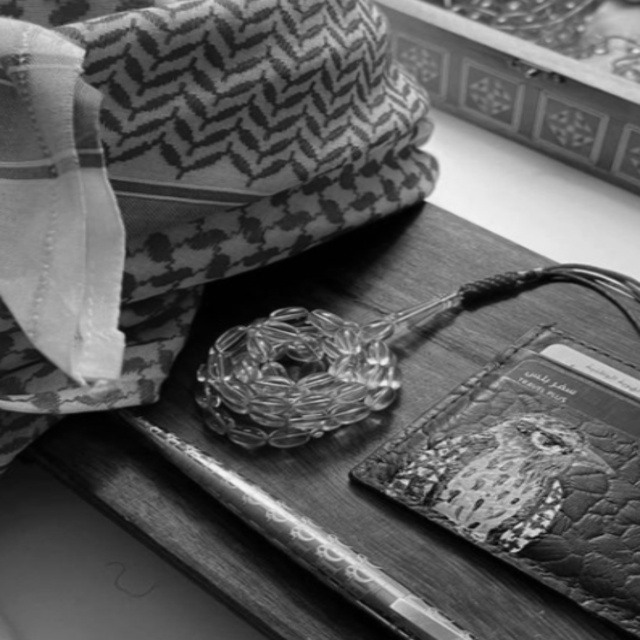

In [ ]:
test_images = glob.glob(os.path.join(root, 'images', 'test', "*.jpg"))
random_idx = random.sample(range(len(test_images)), 1)[0]
results = model11n(test_images[random_idx])

results[0].show()

**Running The Binary Classification Training Based on Given Train Labels & Metadata**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# @title
N_SPLITS=10

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8
)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

cls_csv = pd.read_csv("binary_classification.csv")

cls_csv = cls_csv[(cls_csv['has_head']==1.0)&(cls_csv['has_shemaq']==1.0)]

X = pd.DataFrame(cls_csv.drop(columns=['label', 'img_name']))
y = pd.DataFrame(cls_csv['label'])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


scaler = StandardScaler()
X = scaler.fit_transform(X_resampled)
X = pd.DataFrame(X)

f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_resampled), start=1):
  X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
  y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]


  rf.fit(X_train, y_train)

  pred = rf.predict(X_val)

  f1_scores.append(f1_score(y_val, pred, zero_division=0))


f1 = np.mean(f1_scores)

print(f"F1 Score: {f1:.2f}")
#print(f1_scores)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

F1 Score: 0.96


**Trying Binary Classification with The Addition of Oversampling to Resolve The Highly Noticable Imbalance**

In [ ]:
# @title
rf_oversample = RandomForestClassifier(
    n_estimators=300,
    max_depth=3
)

cls_csv = pd.read_csv("binary_classification.csv")

#cls_csv = cls_csv[(cls_csv['has_head']==1.0)&(cls_csv['has_shemaq']==1.0)]

X = pd.DataFrame(cls_csv.drop(columns=['label', 'img_name']))
y = pd.DataFrame(cls_csv['label']).astype(np.int32)

ros = RandomOverSampler(random_state=42)


scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, y_train, X_val, y_val = train_test_split(X, y, test_size=.3, random_state=42, shuffle=True, stratify=y)

X_train, y_train = ros.fit_resample(X_train, y_train)

rf_oversample.fit(X_train, y_train)
pred = rf_oversample.predict(X_val)

f1_resample = f1_score(y_val, pred, zero_division=0)

print(f1_resample)

ValueError: Unknown label type: continuous-multioutput. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

**Classification Neural Network**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

**Organizing The Data into Tensor Datasets & Data Loaders**

In [ ]:
metadata = pd.read_csv("/content/binary_classification.csv")

X = metadata.drop(columns=['img_name'
, 'label'])
y = metadata['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

BATCH_SIZE=32

train_loader = DataLoader(train_dataset,  batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(f"Training dataset size: {len(train_dataset)}, validation dataset size: {len(val_dataset)}")

Training dataset size: 358, validation dataset size: 90


**Creating The Training & Validation Loop Functions**

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, threshold, device):
  model.train()
  total_loss = 0
  total = 0
  total_f1 = 0

  for X, labels in tqdm(train_loader):
    X, labels = X.to(device), labels.view(-1, 1).to(device)

    outputs = model(X)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pred = (outputs>=threshold)

    total_loss += loss.item()
    total += labels.size(0)
    total_f1 += f1_score(labels.data, pred, zero_division=0)

  avg_loss = total_loss/len(train_loader)
  f1 = total_f1/len(train_loader)

  return avg_loss, f1

In [ ]:
def validate(model, train_loader, criterion, threshold, device):
  model.eval()
  total_loss = 0
  total = 0
  total_f1 = 0

  with torch.no_grad():
    for X, labels in tqdm(train_loader):
      X, labels = X.to(device), labels.view(-1, 1).to(device)

      outputs = model(X)
      loss = criterion(outputs, labels)


      pred = (outputs>=threshold)

      total_loss += loss.item()
      total += labels.size(0)
      total_f1 += f1_score(labels.data, pred, zero_division=0)

  avg_loss = total_loss/len(train_loader)
  f1 = total_f1/len(train_loader)

  return avg_loss, f1

**Building The Classification Neural Network**

In [ ]:
class BinaryClassificationNN(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, dropout_rate1, dropout_rate2):
    super(BinaryClassificationNN, self).__init__()

    self.network = nn.Sequential(
        nn.Linear(in_features, hidden_features),
        nn.BatchNorm1d(hidden_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate1),

        nn.Linear(hidden_features, hidden_features),
        nn.BatchNorm1d(hidden_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate2),

        nn.Linear(hidden_features, hidden_features),
        nn.BatchNorm1d(hidden_features),
        nn.ReLU(inplace=True),

        nn.Linear(hidden_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.network(x)

In [ ]:
# @title
# Reasoning behind choosing the initial dropout rate: using skf will do little good to this huge imbalance, so a better option would be to use a dropout rate after the first activation such that it equals the percentage of the dominant class that needs to be removed in order for the less dominant class to have an almost equal ratio to the dominant one.

# This dropout process will most likely not affect the less dominant class since its ratio is almost negligable (<1%).

# The second dropout rate is used for general regularization of the neural network.

classification_model = BinaryClassificationNN(in_features=8, hidden_features =100, out_features=1, dropout_rate1=.98, dropout_rate2=.2)

THRESHOLD = .4
LEARNING_RATE=.001

optimizer = optim.Adam(classification_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

NUM_EPOCHS = 20

**Training The Classifier**

In [ ]:
# @title
train_losses = []
val_losses = []

train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):

  train_loss, train_f1 = train_one_epoch(classification_model, train_loader, optimizer, criterion, THRESHOLD, device)
  val_loss, val_f1 = validate(classification_model, val_loader, criterion, THRESHOLD,  device)

  train_losses.append(train_loss)
  val_losses.append(val_losses)
  train_f1s.append(train_f1)
  val_f1s.append(val_f1)

  print(f"Epoch[{epoch+1}/{NUM_EPOCHS}] | Training Loss: {train_loss} | Validation Loss: {val_loss} | Training F1 Score: {train_f1} | Validation F1 Score: {val_f1}")

100%|██████████| 3/3 [00:00<00:00, 253.58it/s]


Epoch[1/20] | Training Loss: 0.7177099883556366 | Validation Loss: 0.6961285869280497 | Training F1 Score: 0.01597222222222222 | Validation F1 Score: 0.020202020202020204


100%|██████████| 3/3 [00:00<00:00, 240.42it/s]


Epoch[2/20] | Training Loss: 0.5565384676059087 | Validation Loss: 0.5601998567581177 | Training F1 Score: 0.01215738284703802 | Validation F1 Score: 0.020202020202020204


100%|██████████| 3/3 [00:00<00:00, 207.20it/s]


Epoch[3/20] | Training Loss: 0.43670570353666943 | Validation Loss: 0.43815640608469647 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 228.11it/s]


Epoch[4/20] | Training Loss: 0.33017900089422864 | Validation Loss: 0.29122787714004517 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 194.56it/s]


Epoch[5/20] | Training Loss: 0.26571790625651676 | Validation Loss: 0.20658925672372183 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 192.97it/s]


Epoch[6/20] | Training Loss: 0.20409785335262617 | Validation Loss: 0.14761647085348764 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 195.69it/s]


Epoch[7/20] | Training Loss: 0.17921036730209985 | Validation Loss: 0.1268071879943212 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 188.93it/s]


Epoch[8/20] | Training Loss: 0.15473628602921963 | Validation Loss: 0.10657485822836558 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 203.32it/s]


Epoch[9/20] | Training Loss: 0.1368247987702489 | Validation Loss: 0.08795131742954254 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 167.20it/s]


Epoch[10/20] | Training Loss: 0.1064935199295481 | Validation Loss: 0.06773112093408902 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 166.63it/s]


Epoch[11/20] | Training Loss: 0.1075020384353896 | Validation Loss: 0.06621650482217471 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 196.66it/s]


Epoch[12/20] | Training Loss: 0.09774553899963696 | Validation Loss: 0.06440824456512928 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 208.33it/s]


Epoch[13/20] | Training Loss: 0.09055575728416443 | Validation Loss: 0.06392738098899524 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 193.94it/s]


Epoch[14/20] | Training Loss: 0.07628087932243943 | Validation Loss: 0.060599034652113914 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 165.59it/s]


Epoch[15/20] | Training Loss: 0.07958137368162473 | Validation Loss: 0.06006167953213056 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 230.54it/s]


Epoch[16/20] | Training Loss: 0.07405336170146863 | Validation Loss: 0.05759144977976879 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 200.91it/s]


Epoch[17/20] | Training Loss: 0.07352469504500429 | Validation Loss: 0.05761008926977714 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 203.86it/s]


Epoch[18/20] | Training Loss: 0.06122427977000674 | Validation Loss: 0.05747751208643118 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 204.22it/s]


Epoch[19/20] | Training Loss: 0.06540003574142854 | Validation Loss: 0.05735216103494167 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 155.75it/s]

Epoch[20/20] | Training Loss: 0.06215126579627395 | Validation Loss: 0.0575888796399037 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


**NN Classifier with Stratified K-Fold**

In [ ]:
# @title
from sklearn.model_selection import StratifiedKFold

N_SPLITS= 5

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)


In [ ]:
# @title
train_losses = []
val_losses = []

train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):
  skf_train_loss = []
  skf_val_loss = []
  skf_train_f1 = []
  skf_val_f1 = []

  for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)

    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    y_val = torch.tensor(y_val.values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)


    train_loader = DataLoader(train_dataset,  batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    train_loss, train_f1 = train_one_epoch(classification_model, train_loader, optimizer, criterion, THRESHOLD, device)
    val_loss, val_f1 = validate(classification_model, val_loader, criterion, THRESHOLD,  device)

    skf_train_loss.append(train_loss)
    skf_val_loss.append(val_loss)
    skf_train_f1.append(train_f1)
    skf_val_f1.append(val_f1)

  train_loss = np.mean(skf_train_loss)
  val_loss = np.mean(skf_val_loss)
  train_f1 = np.mean(skf_train_f1)
  val_f1= np.mean(skf_val_f1)

  train_losses.append(train_loss)
  val_losses.append(val_losses)
  train_f1s.append(train_f1)
  val_f1s.append(val_f1)

  print(f"Epoch[{epoch+1}/{NUM_EPOCHS}] | Training Loss: {train_loss} | Validation Loss: {val_loss} | Training F1 Score: {train_f1} | Validation F1 Score: {val_f1}")

100%|██████████| 3/3 [00:00<00:00, 215.61it/s]


Epoch[1/20] | Training Loss: 0.0663433390048643 | Validation Loss: 0.06500006841185194 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 218.16it/s]


Epoch[2/20] | Training Loss: 0.061219600184510156 | Validation Loss: 0.06649721378150085 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 166.03it/s]


Epoch[3/20] | Training Loss: 0.061999378089482596 | Validation Loss: 0.06646273784960309 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 207.57it/s]


Epoch[4/20] | Training Loss: 0.0644852378560851 | Validation Loss: 0.07021186251658948 | Training F1 Score: 0.016666666666666666 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 189.42it/s]


Epoch[5/20] | Training Loss: 0.05475751449509213 | Validation Loss: 0.0638719900821646 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 186.67it/s]


Epoch[6/20] | Training Loss: 0.05852919125463814 | Validation Loss: 0.06501944538516304 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 174.72it/s]


Epoch[7/20] | Training Loss: 0.05895508324416976 | Validation Loss: 0.06687261362870535 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 150.47it/s]


Epoch[8/20] | Training Loss: 0.05701424039434642 | Validation Loss: 0.06392167597077787 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 173.35it/s]


Epoch[9/20] | Training Loss: 0.06115502356551587 | Validation Loss: 0.06668462778907269 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 156.37it/s]


Epoch[10/20] | Training Loss: 0.05211593743879348 | Validation Loss: 0.06573606031015515 | Training F1 Score: 0.03333333333333333 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 136.38it/s]


Epoch[11/20] | Training Loss: 0.06392631322766343 | Validation Loss: 0.06740165620576591 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 195.68it/s]


Epoch[12/20] | Training Loss: 0.05421395165612921 | Validation Loss: 0.06794072437720994 | Training F1 Score: 0.016666666666666666 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 215.10it/s]


Epoch[13/20] | Training Loss: 0.060522673395462336 | Validation Loss: 0.06646029947636029 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 167.45it/s]


Epoch[14/20] | Training Loss: 0.05267907785406958 | Validation Loss: 0.06677360914181918 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 220.34it/s]


Epoch[15/20] | Training Loss: 0.05352542535401881 | Validation Loss: 0.07028452074543262 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 198.86it/s]


Epoch[16/20] | Training Loss: 0.05616849160287529 | Validation Loss: 0.06905110493147124 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 164.55it/s]


Epoch[17/20] | Training Loss: 0.05244242754609635 | Validation Loss: 0.07105003947314495 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 232.14it/s]


Epoch[18/20] | Training Loss: 0.051395091860710326 | Validation Loss: 0.0699655650416389 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 223.24it/s]


Epoch[19/20] | Training Loss: 0.05438018176549425 | Validation Loss: 0.07060732475171486 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


100%|██████████| 3/3 [00:00<00:00, 209.64it/s]

Epoch[20/20] | Training Loss: 0.05383584317363177 | Validation Loss: 0.0747087039402686 | Training F1 Score: 0.0 | Validation F1 Score: 0.0


In [ ]:
# @title
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.plot(range(1, NUM_EPOCHS+1), train_losses, color='teal', marker='o', label='Training')
ax.plot(range(1, NUM_EPOCHS+1), val_losses, color='orange', marker='o', label='Validation')
ax.set_xlabel("Epoch")
ax.set_ylabel("BCE Loss")
ax.set_title("Loss vs. Epoch")
ax.legend()
ax.grid()

ax = axes[1]
ax.plot(range(1, NUM_EPOCHS+1), train_f1s, color='teal', marker='o', label='Training')
ax.plot(range(1, NUM_EPOCHS+1), val_f1s, color='orange', marker='o', label='Validation')
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score vs. Epoch")
ax.legend()
ax.grid()

plt.show()

In [ ]:
# Not using Stratified K-Fold give more stable results for both the training and validation

0.0


**Another Idea to Fix Imbalance: Create More Data for The Non-Dominant Class Using Geometric Augmentations of The Available Images Belonging to It and Find Its Features Using The Trained Model Then Add Them to The Metadata**

In [ ]:
# @title
import torchvision
from torchvision import transforms
import torchvision.transforms.v2 as v2
from torchvision.transforms import ToTensor, ToPILImage

metadata= pd.read_csv("/content/binary_classification.csv")

# We have 5 true labels and 646 false labels, so we need ~ 130 augmentation transforms to apply to all true label images
# one way of making this easier is to use 6 different geometric augmentations and randomly choose a subset of them to use on the images multiple times, the order will make a difference for most of our choice of geometric transformations. This means that if we use 3 different augmentations and apply a random permutation to each image 125 times will result in 625 augmentations of the images.

non_dominant_class_images = metadata[metadata['label']==1]['img_name'].tolist()


aug_transform_1 = v2.RandomRotation(degrees=(0, 20))

aug_transform_2 = v2.RandomPerspective(distortion_scale=0.04, p=1.0)

aug_transform_3 = v2.RandomAffine(degrees=(10, 15), translate=(0.1, 0.2))

aug_transform_4 = v2.AugMix()

aug_transform_5 = v2.Resize(size=600)

aug_transform_6 = transforms.RandomHorizontalFlip(p=.7)

aug_transform_7 = v2.Pad(padding=10)

aug_transform_8 = v2.ElasticTransform(alpha=30)


augmentations = [
    aug_transform_1,
    aug_transform_2,
    aug_transform_3,
    aug_transform_4,
    aug_transform_5,
    aug_transform_6,
    aug_transform_7,
    aug_transform_8,
]



In [ ]:
model = YOLO("/content/yolov11n_finetuned.pt")
path_to_augmented_images = "/content/drive/MyDrive/Datasets/Augmented_Positive_Images"

In [ ]:
# @title
images = []

for img in non_dominant_class_images:
  images.append(os.path.join(all_images_path, "train", img))

print(len(images))

for i, image in enumerate(images):
  image = Image.open(image)

  for j in range(200):
    random_indices = random.sample(range(len(augmentations)), 3)
    transformations = [augmentations[k] for k in random_indices]
    random.shuffle(transformations)

    new_img = image

    for transformation in transformations:
      new_img = transformation(new_img)

    new_img.save(os.path.join(path_to_augmented_images, f"{651+(i+1)*j}.jpg"))



5


In [ ]:
# @title

augmented_images = glob.glob(os.path.join(path_to_augmented_images, "*.jpg"))

X = []
labels = []

for image in augmented_images:

  img_name = image.split("/")[-1]



  right_place = 1

  objects = [] # to store shemaqs and heads found in the labels file
  data_lines= []

  areas = []
  widths = []
  heights = []

  Xmin_0 = []
  Xmax_0 = []
  Xmin_1 = []
  Xmax_1 = []

  Ymin_0 = []
  Ymax_0 = []
  Ymin_1 = []
  Ymax_1 = []

  max_iou = 0
  min_distance = 640

  names = []

  results = model.predict(image, conf=.25, verbose=False)[0]

  if len(results.boxes) == 0:
    continue

  for box in results.boxes:
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    x, y, w, h = box.xywhn[0].tolist()
    data_lines.append([x, y, w, h])
    objects.append(cls)


  for i, line in enumerate(data_lines):  # Iterate through the results objects

    x, y, w, h = line
    xmin, ymin, xmax, ymax = x-w/2, y-h/2, x+w/2, y+h/2

    area = (w)*(h)

    areas.append(np.abs(area))
    widths.append(w)
    heights.append(h)

    if objects[i] == 0:
      Xmin_0.append(xmin)
      Xmax_0.append(xmax)
      Ymin_0.append(ymin)
      Ymax_0.append(ymax)
    elif objects[i] == 1:
      Xmin_1.append(xmin)
      Xmax_1.append(xmax)
      Ymin_1.append(ymin)
      Ymax_1.append(ymax)


    Xmin_0_np = np.array(Xmin_0)
    Xmin_1_np = np.array(Xmin_1)
    Xmax_0_np = np.array(Xmax_0)
    Xmax_1_np = np.array(Xmax_1)
    Ymin_0_np = np.array(Ymin_0)
    Ymin_1_np = np.array(Ymin_1)
    Ymax_0_np = np.array(Ymax_0)
    Ymax_1_np = np.array(Ymax_1)

    vec = np.array([xmin, ymin, xmax, ymax])

    if objects[i] == 0:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_1_np, Xmax_1_np, Ymin_1_np, Ymax_1_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_1_np+Xmax_1_np)/2)*(x-(Xmin_1_np+Xmax_1_np)/2)))+((y-(Ymin_1_np+Ymax_1_np)/2)*(y-(Ymin_1_np+Ymax_1_np)/2)))
      except ValueError:
        min_found_dist = 640

      min_distance = min(min_distance, min_found_dist)

    elif objects[i] == 1:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_0_np, Xmax_0_np, Ymin_0_np, Ymax_0_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_0_np+Xmax_0_np)/2)*(x-(Xmin_0_np+Xmax_0_np)/2)))+((y-(Ymin_0_np+Ymax_0_np)/2)*(y-(Ymin_0_np+Ymax_0_np)/2)))
      except ValueError:
        min_found_dist = 640


      min_distance = min(min_distance, min_found_dist)


  has_shemaq = 1
  has_head = 1
  features = [] # creating a feature vector for this image
  features.append(img_name)
  features.append(has_shemaq)
  features.append(has_head)
  features.append(np.mean(areas))
  features.append(np.mean(heights))
  features.append(np.mean(widths))
  features.append(max_iou)
  features.append(min_distance)


  X.append(features) # appending to full feature vector
  labels.append(right_place) # appending label


In [ ]:
# @title
cls_df = pd.DataFrame(X, columns=['img_name', 'has_shemaq','has_head', 'mean_box_area', 'mean_box_height', 'mean_box_width', 'max_iou', 'min_distance'])
cls_df['label'] = labels


In [ ]:
# @title
cls_df['mean_abs_box_diagonal_slope'] = cls_df['mean_box_height']/cls_df['mean_box_width']

In [ ]:
cls_df.drop_duplicates(inplace=True)
print(cls_df.shape)

(586, 10)


In [ ]:
# @title
cls_df.to_csv("binary_classification_aug_data.csv", index=False)

In [ ]:
original_data = pd.read_csv("/content/binary_classification.csv")
new_data= pd.read_csv("/content/binary_classification_aug_data.csv")
new_data = new_data.iloc[:400,]
all_data = pd.concat([original_data, new_data], axis=0)

#Removing Duplicates
all_data.drop_duplicates(inplace=True)
all_data.to_csv("Final_Metadata.csv", index=False)
all_data.shape

(848, 10)

**This Time Trying Geometric & Color Augmentations for Better Generalization + Using YOLO9t Instead**

In [ ]:
# @title
import torchvision
from torchvision import transforms
import torchvision.transforms.v2 as v2
from torchvision.transforms import ToTensor, ToPILImage

metadata= pd.read_csv("/content/binary_classification.csv")

# We have 5 true labels and 646 false labels, so we need ~ 130 augmentation transforms to apply to all true label images
# one way of making this easier is to use 6 different geometric augmentations and randomly choose a subset of them to use on the images multiple times, the order will make a difference for most of our choice of geometric transformations. This means that if we use 3 different augmentations and apply a random permutation to each image 125 times will result in 625 augmentations of the images.

non_dominant_class_images = metadata[metadata['label']==1]['img_name'].tolist()


aug_transform_1 = v2.RandomRotation(degrees=(0, 20))

aug_transform_2 = v2.RandomPerspective(distortion_scale=0.04, p=1.0)

aug_transform_3 = v2.RandomAffine(degrees=(10, 15), translate=(0.1, 0.2))

aug_transform_4 = v2.AugMix()

aug_transform_5 = v2.Resize(size=600)

aug_transform_6 = transforms.RandomHorizontalFlip(p=.7)

aug_transform_7 = v2.Pad(padding=10)

aug_transform_8 = v2.ElasticTransform(alpha=30)

aug_transform_9 = v2.ColorJitter(brightness=.3, hue=.3)

aug_transform_10 = v2.RandomInvert()

aug_transform_11 = v2.RandomSolarize(threshold=192.0)


augmentations = [
    aug_transform_1,
    aug_transform_2,
    aug_transform_3,
    aug_transform_4,
    aug_transform_5,
    aug_transform_6,
    aug_transform_7,
    aug_transform_8,
    aug_transform_9,
    aug_transform_10,
    aug_transform_11
]



In [ ]:
model = YOLO("/content/yolo9t_finetuned.pt")
path_to_color_augmented_images = "/content/drive/MyDrive/Datasets/Color_Augmented_Positive_Images"

In [ ]:
# @title
images = []

for img in non_dominant_class_images:
  images.append(os.path.join(all_images_path, "train", img))

print(len(images))

for i, image in enumerate(images):
  image = Image.open(image)

  for j in range(200):
    random_indices = random.sample(range(len(augmentations)), 3)
    transformations = [augmentations[k] for k in random_indices]
    random.shuffle(transformations)

    new_img = image

    for transformation in transformations:
      new_img = transformation(new_img)

    new_img.save(os.path.join(path_to_color_augmented_images, f"{651+(i+1)*j}.jpg"))



5


In [ ]:
# @title

augmented_images = glob.glob(os.path.join(path_to_color_augmented_images, "*.jpg"))

X = []
labels = []

for image in augmented_images:

  img_name = image.split("/")[-1]



  right_place = 1

  objects = [] # to store shemaqs and heads found in the labels file
  data_lines= []

  areas = []
  widths = []
  heights = []

  Xmin_0 = []
  Xmax_0 = []
  Xmin_1 = []
  Xmax_1 = []

  Ymin_0 = []
  Ymax_0 = []
  Ymin_1 = []
  Ymax_1 = []

  max_iou = 0
  min_distance = 640

  names = []

  results = model.predict(image, conf=.25, verbose=False)[0]

  if len(results.boxes) == 0:
    continue

  for box in results.boxes:
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    x, y, w, h = box.xywhn[0].tolist()
    data_lines.append([x, y, w, h])
    objects.append(cls)


  for i, line in enumerate(data_lines):  # Iterate through the results objects

    x, y, w, h = line
    xmin, ymin, xmax, ymax = x-w/2, y-h/2, x+w/2, y+h/2

    area = (w)*(h)

    areas.append(np.abs(area))
    widths.append(w)
    heights.append(h)

    if objects[i] == 0:
      Xmin_0.append(xmin)
      Xmax_0.append(xmax)
      Ymin_0.append(ymin)
      Ymax_0.append(ymax)
    elif objects[i] == 1:
      Xmin_1.append(xmin)
      Xmax_1.append(xmax)
      Ymin_1.append(ymin)
      Ymax_1.append(ymax)


    Xmin_0_np = np.array(Xmin_0)
    Xmin_1_np = np.array(Xmin_1)
    Xmax_0_np = np.array(Xmax_0)
    Xmax_1_np = np.array(Xmax_1)
    Ymin_0_np = np.array(Ymin_0)
    Ymin_1_np = np.array(Ymin_1)
    Ymax_0_np = np.array(Ymax_0)
    Ymax_1_np = np.array(Ymax_1)

    vec = np.array([xmin, ymin, xmax, ymax])

    if objects[i] == 0:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_1_np, Xmax_1_np, Ymin_1_np, Ymax_1_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_1_np+Xmax_1_np)/2)*(x-(Xmin_1_np+Xmax_1_np)/2)))+((y-(Ymin_1_np+Ymax_1_np)/2)*(y-(Ymin_1_np+Ymax_1_np)/2)))
      except ValueError:
        min_found_dist = 640

      min_distance = min(min_distance, min_found_dist)

    elif objects[i] == 1:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_0_np, Xmax_0_np, Ymin_0_np, Ymax_0_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_0_np+Xmax_0_np)/2)*(x-(Xmin_0_np+Xmax_0_np)/2)))+((y-(Ymin_0_np+Ymax_0_np)/2)*(y-(Ymin_0_np+Ymax_0_np)/2)))
      except ValueError:
        min_found_dist = 640


      min_distance = min(min_distance, min_found_dist)


  has_shemaq = 1
  has_head = 1
  features = [] # creating a feature vector for this image
  features.append(img_name)
  features.append(has_shemaq)
  features.append(has_head)
  features.append(np.mean(areas))
  features.append(np.mean(heights))
  features.append(np.mean(widths))
  features.append(max_iou)
  features.append(min_distance)


  X.append(features) # appending to full feature vector
  labels.append(right_place) # appending label


In [ ]:
# @title
cls_df = pd.DataFrame(X, columns=['img_name', 'has_shemaq','has_head', 'mean_box_area', 'mean_box_height', 'mean_box_width', 'max_iou', 'min_distance'])
cls_df['label'] = labels


In [ ]:
# @title
cls_df['mean_abs_box_diagonal_slope'] = cls_df['mean_box_height']/cls_df['mean_box_width']

In [ ]:
cls_df.drop_duplicates(inplace=True)
print(cls_df.shape)

(514, 10)


In [ ]:
# @title
cls_df.to_csv("binary_classification_color_aug_data.csv", index=False)

In [ ]:
original_data = pd.read_csv("/content/binary_classification.csv")
new_data= pd.read_csv("/content/binary_classification_aug_data.csv")
new_data = new_data.iloc[:512,]
all_color_data = pd.concat([original_data, new_data], axis=0)

#Removing Duplicates
all_color_data.drop_duplicates(inplace=True)
all_color_data.to_csv("Final_Metadata.csv", index=False)
all_color_data.shape

(960, 10)

**Applying The Classification Model With Equal Data For Both Classes**

In [ ]:
# @title
# Now that the data is balanced, we can use the same dropout rate and make it low

metadata = pd.read_csv("/content/Final_Metadata.csv")

X = metadata.drop(columns=['img_name'
, 'label'])
y = metadata['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

BATCH_SIZE=32

train_loader = DataLoader(train_dataset,  batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
classification_model_ = BinaryClassificationNN(in_features=8, hidden_features =32, out_features=1, dropout_rate1=.4, dropout_rate2=.4)

THRESHOLD = .5
LEARNING_RATE=.003

optimizer = optim.Adam(classification_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

NUM_EPOCHS = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_losses = []
val_losses = []

train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):

  train_loss, train_f1 = train_one_epoch(classification_model_, train_loader, optimizer, criterion, THRESHOLD, device)
  val_loss, val_f1 = validate(classification_model_, val_loader, criterion, THRESHOLD,  device)

  train_losses.append(train_loss)
  val_losses.append(val_losses)
  train_f1s.append(train_f1)
  val_f1s.append(val_f1)

  print(f"Epoch[{epoch+1}/{NUM_EPOCHS}] | Training Loss: {train_loss} | Validation Loss: {val_loss} | Training F1 Score: {train_f1} | Validation F1 Score: {val_f1}")

100%|██████████| 6/6 [00:00<00:00, 219.65it/s]


Epoch[1/15] | Training Loss: 0.9411923363804817 | Validation Loss: 0.7547196447849274 | Training F1 Score: 0.4117003461453521 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 211.24it/s]


Epoch[2/15] | Training Loss: 0.9307984660069147 | Validation Loss: 0.8043712476889292 | Training F1 Score: 0.4258964379022205 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 202.70it/s]


Epoch[3/15] | Training Loss: 0.9613482082883517 | Validation Loss: 0.8081270754337311 | Training F1 Score: 0.40433285959180426 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 213.09it/s]


Epoch[4/15] | Training Loss: 0.9331679716706276 | Validation Loss: 0.8153127729892731 | Training F1 Score: 0.4244324923859794 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 204.97it/s]


Epoch[5/15] | Training Loss: 0.9479502265652021 | Validation Loss: 0.8154636025428772 | Training F1 Score: 0.4187915433823662 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 205.61it/s]


Epoch[6/15] | Training Loss: 0.9474735707044601 | Validation Loss: 0.8154746095339457 | Training F1 Score: 0.4331650876517066 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 221.48it/s]


Epoch[7/15] | Training Loss: 0.9254383717974027 | Validation Loss: 0.8086595137914022 | Training F1 Score: 0.43913005110173636 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 202.81it/s]


Epoch[8/15] | Training Loss: 0.9372119953234991 | Validation Loss: 0.8198778132597605 | Training F1 Score: 0.4163786545037795 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 226.69it/s]


Epoch[9/15] | Training Loss: 0.9375021060307821 | Validation Loss: 0.818953812122345 | Training F1 Score: 0.4141967151158328 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 197.77it/s]


Epoch[10/15] | Training Loss: 0.9392121657729149 | Validation Loss: 0.8199117581049601 | Training F1 Score: 0.41380235273824484 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 231.22it/s]


Epoch[11/15] | Training Loss: 0.9668729354937872 | Validation Loss: 0.8239386876424154 | Training F1 Score: 0.4007253093721934 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 217.51it/s]


Epoch[12/15] | Training Loss: 0.9578186124563217 | Validation Loss: 0.8149652083714803 | Training F1 Score: 0.40203647638041656 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 242.49it/s]


Epoch[13/15] | Training Loss: 0.9556116287906965 | Validation Loss: 0.7950707276662191 | Training F1 Score: 0.40684349516715673 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 186.67it/s]


Epoch[14/15] | Training Loss: 0.9562839940190315 | Validation Loss: 0.8201597531636556 | Training F1 Score: 0.4024649253597466 | Validation F1 Score: 0.6965199161425577


100%|██████████| 6/6 [00:00<00:00, 220.09it/s]

Epoch[15/15] | Training Loss: 0.9756601353486379 | Validation Loss: 0.8191252946853638 | Training F1 Score: 0.3916585079911818 | Validation F1 Score: 0.6965199161425577


In [ ]:
torch.save(classification_model.state_dict(), "classification_model_best.pt")

**Applying The Classification Model With Equal Data For Both Classes On Color Augmented Images**

In [ ]:
# Now that the data is balanced, we can use the same dropout rate and make it low

metadata = pd.read_csv("/content/Final_Metadata_Colored.csv")

X = metadata.drop(columns=['img_name'
, 'label'])
y = metadata['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

BATCH_SIZE=32

train_loader = DataLoader(train_dataset,  batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
classification_model = BinaryClassificationNN(in_features=8, hidden_features =32, out_features=1, dropout_rate1=.2, dropout_rate2=.2)


THRESHOLD = .5
LEARNING_RATE=.003

optimizer = optim.Adam(classification_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

NUM_EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_losses = []
val_losses = []

train_f1s = []
val_f1s = []

for epoch in range(NUM_EPOCHS):

  train_loss, train_f1 = train_one_epoch(classification_model_, train_loader, optimizer, criterion, THRESHOLD, device)
  val_loss, val_f1 = validate(classification_model_, val_loader, criterion, THRESHOLD,  device)

  train_losses.append(train_loss)
  val_losses.append(val_losses)
  train_f1s.append(train_f1)
  val_f1s.append(val_f1)

  print(f"Epoch[{epoch+1}/{NUM_EPOCHS}] | Training Loss: {train_loss} | Validation Loss: {val_loss} | Training F1 Score: {train_f1} | Validation F1 Score: {val_f1}")

100%|██████████| 6/6 [00:00<00:00, 208.76it/s]


Epoch[1/20] | Training Loss: 0.7202974955240885 | Validation Loss: 0.6055487294991811 | Training F1 Score: 0.5851540889805207 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 219.62it/s]


Epoch[2/20] | Training Loss: 0.7111802150805792 | Validation Loss: 0.6097759405771891 | Training F1 Score: 0.5854499598448091 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 206.80it/s]


Epoch[3/20] | Training Loss: 0.7371305227279663 | Validation Loss: 0.6031253933906555 | Training F1 Score: 0.5417309942640643 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 219.60it/s]


Epoch[4/20] | Training Loss: 0.728783905506134 | Validation Loss: 0.6079475382963816 | Training F1 Score: 0.5814166773028872 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 201.05it/s]


Epoch[5/20] | Training Loss: 0.6901233593622843 | Validation Loss: 0.6112683514753977 | Training F1 Score: 0.6239341562682295 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 183.60it/s]


Epoch[6/20] | Training Loss: 0.7152362888058027 | Validation Loss: 0.6121266484260559 | Training F1 Score: 0.5981438364272437 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 220.52it/s]


Epoch[7/20] | Training Loss: 0.7454385707775751 | Validation Loss: 0.6142322421073914 | Training F1 Score: 0.5908184330776768 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 191.61it/s]


Epoch[8/20] | Training Loss: 0.7220621878902117 | Validation Loss: 0.6078888277212778 | Training F1 Score: 0.592831882660687 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 230.90it/s]


Epoch[9/20] | Training Loss: 0.7260763620336851 | Validation Loss: 0.6095001101493835 | Training F1 Score: 0.5967120283719295 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 144.23it/s]


Epoch[10/20] | Training Loss: 0.7202780619263649 | Validation Loss: 0.6122836867968241 | Training F1 Score: 0.5962660221428132 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 164.08it/s]


Epoch[11/20] | Training Loss: 0.725199023882548 | Validation Loss: 0.6086247364679972 | Training F1 Score: 0.5655657081818887 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 165.45it/s]


Epoch[12/20] | Training Loss: 0.7048474177718163 | Validation Loss: 0.6073563496271769 | Training F1 Score: 0.6085383966926469 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 131.59it/s]


Epoch[13/20] | Training Loss: 0.7172154958049456 | Validation Loss: 0.6051657299200693 | Training F1 Score: 0.5836373298107095 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 164.58it/s]


Epoch[14/20] | Training Loss: 0.693555049598217 | Validation Loss: 0.6192859013875326 | Training F1 Score: 0.5920310048184975 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 171.95it/s]


Epoch[15/20] | Training Loss: 0.735412726799647 | Validation Loss: 0.6074787080287933 | Training F1 Score: 0.5886624683910733 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 176.95it/s]


Epoch[16/20] | Training Loss: 0.7528181398908297 | Validation Loss: 0.6190955837567648 | Training F1 Score: 0.5708051517598306 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 177.98it/s]


Epoch[17/20] | Training Loss: 0.7222676078478495 | Validation Loss: 0.6120654841264089 | Training F1 Score: 0.5790049384053447 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 148.12it/s]


Epoch[18/20] | Training Loss: 0.7353828400373459 | Validation Loss: 0.6206156810124716 | Training F1 Score: 0.580640440682343 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 156.86it/s]


Epoch[19/20] | Training Loss: 0.7222175523638725 | Validation Loss: 0.6076170106728872 | Training F1 Score: 0.5834140827862532 | Validation F1 Score: 0.8134222397521488


100%|██████████| 6/6 [00:00<00:00, 165.42it/s]

Epoch[20/20] | Training Loss: 0.7377903982996941 | Validation Loss: 0.6120921671390533 | Training F1 Score: 0.5730211015874652 | Validation F1 Score: 0.8134222397521488


In [ ]:
torch.save(classification_model.state_dict(), "classification_model_best.pt")

**Applying The Whole Pipeline to The Testing Data**

**Testing With YOLOv11n For Detection**

In [ ]:
classification_model = BinaryClassificationNN(in_features=8, hidden_features =32, out_features=1, dropout_rate1=.4, dropout_rate2=.4)

state_dict = torch.load("/content/classification_model_best.pt")

classification_model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
submission_data = []

In [ ]:
model = YOLO("/content/yolov11n_finetuned.pt")

In [ ]:
# @title

test_images = glob.glob(os.path.join("/content/drive/MyDrive/Datasets/Shemaq Challenge Dal", "images", "test", "*.jpg"))


for image in test_images:

  img_name = image.split("/")[-1]


  objects = [] # to store shemaqs and heads found in the labels file
  data_lines= []
  prediction_strings = []

  areas = []
  widths = []
  heights = []

  Xmin_0 = []
  Xmax_0 = []
  Xmin_1 = []
  Xmax_1 = []

  Ymin_0 = []
  Ymax_0 = []
  Ymin_1 = []
  Ymax_1 = []

  scores = []
  max_iou = 0
  min_distance = 640


  results = model.predict(image, conf=0.25, verbose=False)[0]

  prediction_strings = []

  if len(results.boxes) == 0:
      prediction_str = "-"
      right_place = 0

  else:
      for box in results.boxes:
          cls = int(box.cls[0])
          conf = float(box.conf[0])
          x, y, w, h = box.xywhn[0].tolist()


          data_lines.append([x, y, w, h])
          prediction_strings.append(f"{cls} {conf:.4f} {x:.4f} {y:.4f} {w:.4f} {h:.4f}")

          objects.append(cls)

      prediction_str = " ".join(prediction_strings)






  for i, line in enumerate(data_lines):  # Iterate through the results objects

    x, y, w, h = line
    xmin, ymin, xmax, ymax = x-w/2, y-h/2, x+w/2, y+h/2
    area = (w)*(h)

    areas.append(w*h)
    widths.append(w)
    heights.append(h)

    if objects[i] == 0:
      Xmin_0.append(xmin)
      Xmax_0.append(xmax)
      Ymin_0.append(ymin)
      Ymax_0.append(ymax)
    elif objects[i] == 1:
      Xmin_1.append(xmin)
      Xmax_1.append(xmax)
      Ymin_1.append(ymin)
      Ymax_1.append(ymax)


    Xmin_0_np = np.array(Xmin_0)
    Xmin_1_np = np.array(Xmin_1)
    Xmax_0_np = np.array(Xmax_0)
    Xmax_1_np = np.array(Xmax_1)
    Ymin_0_np = np.array(Ymin_0)
    Ymin_1_np = np.array(Ymin_1)
    Ymax_0_np = np.array(Ymax_0)
    Ymax_1_np = np.array(Ymax_1)

    vec = np.array([xmin, ymin, xmax, ymax])

    if objects[i] == 0:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_1_np, Xmax_1_np, Ymin_1_np, Ymax_1_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_1_np+Xmax_1_np)/2)*(x-(Xmin_1_np+Xmax_1_np)/2)))+((y-(Ymin_1_np+Ymax_1_np)/2)*(y-(Ymin_1_np+Ymax_1_np)/2)))
      except ValueError:
        min_found_dist = 640

      min_distance = min(min_distance, min_found_dist)

    elif objects[i] == 1:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_0_np, Xmax_0_np, Ymin_0_np, Ymax_0_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_0_np+Xmax_0_np)/2)*(x-(Xmin_0_np+Xmax_0_np)/2)))+((y-(Ymin_0_np+Ymax_0_np)/2)*(y-(Ymin_0_np+Ymax_0_np)/2)))
      except ValueError:
        min_found_dist = 640


      min_distance = min(min_distance, min_found_dist)


  has_shemaq = 1 if 1 in objects else 0
  has_head = 1 if 0 in objects else 0
  features = [] # creating a feature vector for this image
  features.append(has_shemaq)
  features.append(has_head)
  features.append(np.mean(areas))
  features.append(np.mean(heights))
  features.append(np.mean(widths))
  features.append(max_iou)
  features.append(min_distance)
  features.append(np.mean(np.array(heights)/(np.array(widths))))

  features = np.array(features, dtype=np.float32)
  features = torch.from_numpy(features)

  classification_model.eval()
  with torch.no_grad():
    right_place = float(classification_model(features.unsqueeze(0)).cpu())
    right_place = right_place>.5

  submission_data.append([img_name, right_place, prediction_str])





/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
df_sub = pd.DataFrame(submission_data, columns=['filename', 'right_place', 'prediction_string'])
df_sub.to_csv('submission1_11n_best.csv', index=False)

In [ ]:
df_sub[df_sub['right_place']==1].shape

(473, 3)

In [ ]:
df_sub.shape

(842, 3)

**Testing Results With The YOLOv9t**

In [ ]:
model = YOLO("/content/yolo9t_finetuned.pt")


In [ ]:
classification_model = classification_model = BinaryClassificationNN(in_features=8, hidden_features =32, out_features=1, dropout_rate1=.4, dropout_rate2=.4)

state_dict = torch.load("/content/classification_model_best.pt")

classification_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
submission_data = []

In [ ]:
# @title

test_images = glob.glob(os.path.join("/content/drive/MyDrive/Datasets/Shemaq Challenge Dal", "images", "test", "*.jpg"))


for image in test_images:

  img_name = image.split("/")[-1]


  objects = [] # to store shemaqs and heads found in the labels file
  data_lines= []
  prediction_strings = []

  areas = []
  widths = []
  heights = []

  Xmin_0 = []
  Xmax_0 = []
  Xmin_1 = []
  Xmax_1 = []

  Ymin_0 = []
  Ymax_0 = []
  Ymin_1 = []
  Ymax_1 = []

  scores = []
  max_iou = 0
  min_distance = 640


  results = model.predict(image, conf=0.25, verbose=False)[0]

  prediction_strings = []

  if len(results.boxes) == 0:
      prediction_str = "-"
      right_place = 0

  else:
      for box in results.boxes:
          cls = int(box.cls[0])
          conf = float(box.conf[0])
          x, y, w, h = box.xywhn[0].tolist()


          data_lines.append([x, y, w, h])
          prediction_strings.append(f"{cls} {conf:.4f} {x:.4f} {y:.4f} {w:.4f} {h:.4f}")

          objects.append(cls)

      prediction_str = " ".join(prediction_strings)






  for i, line in enumerate(data_lines):  # Iterate through the results objects

    x, y, w, h = line
    xmin, ymin, xmax, ymax = x-w/2, y-h/2, x+w/2, y+h/2
    area = (w)*(h)

    areas.append(w*h)
    widths.append(w)
    heights.append(h)

    if objects[i] == 0:
      Xmin_0.append(xmin)
      Xmax_0.append(xmax)
      Ymin_0.append(ymin)
      Ymax_0.append(ymax)
    elif objects[i] == 1:
      Xmin_1.append(xmin)
      Xmax_1.append(xmax)
      Ymin_1.append(ymin)
      Ymax_1.append(ymax)


    Xmin_0_np = np.array(Xmin_0)
    Xmin_1_np = np.array(Xmin_1)
    Xmax_0_np = np.array(Xmax_0)
    Xmax_1_np = np.array(Xmax_1)
    Ymin_0_np = np.array(Ymin_0)
    Ymin_1_np = np.array(Ymin_1)
    Ymax_0_np = np.array(Ymax_0)
    Ymax_1_np = np.array(Ymax_1)

    vec = np.array([xmin, ymin, xmax, ymax])

    if objects[i] == 0:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_1_np, Xmax_1_np, Ymin_1_np, Ymax_1_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_1_np+Xmax_1_np)/2)*(x-(Xmin_1_np+Xmax_1_np)/2)))+((y-(Ymin_1_np+Ymax_1_np)/2)*(y-(Ymin_1_np+Ymax_1_np)/2)))
      except ValueError:
        min_found_dist = 640

      min_distance = min(min_distance, min_found_dist)

    elif objects[i] == 1:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_0_np, Xmax_0_np, Ymin_0_np, Ymax_0_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_0_np+Xmax_0_np)/2)*(x-(Xmin_0_np+Xmax_0_np)/2)))+((y-(Ymin_0_np+Ymax_0_np)/2)*(y-(Ymin_0_np+Ymax_0_np)/2)))
      except ValueError:
        min_found_dist = 640


      min_distance = min(min_distance, min_found_dist)


  has_shemaq = 1 if 1 in objects else 0
  has_head = 1 if 0 in objects else 0
  features = [] # creating a feature vector for this image
  features.append(has_shemaq)
  features.append(has_head)
  features.append(np.mean(areas))
  features.append(np.mean(heights))
  features.append(np.mean(widths))
  features.append(max_iou)
  features.append(min_distance)
  features.append(np.mean(np.array(heights)/(np.array(widths))))

  features = np.array(features, dtype=np.float32)
  features = torch.from_numpy(features)

  classification_model.eval()
  with torch.no_grad():
    right_place = float(classification_model(features.unsqueeze(0)).cpu())
    right_place = right_place>.5

  submission_data.append([img_name, right_place, prediction_str])





In [ ]:
df_sub = pd.DataFrame(submission_data, columns=['filename', 'right_place', 'prediction_string'])
df_sub.to_csv('submission1_9t_best.csv', index=False)

In [ ]:
df_sub[df_sub['right_place']==1].shape

(466, 3)

In [ ]:
df_sub.shape

(842, 3)

**Testing Results With The YOLOv8n**

In [ ]:
model = YOLO("/content/yolo8n_baseline_with_augmentations0.pt")


In [ ]:
classification_model=BinaryClassificationNN(in_features=8, hidden_features =16, out_features=1, dropout_rate1=.4, dropout_rate2=.4)

state_dict = torch.load("/content/classification_model_colored.pt")

classification_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
submission_data = []

In [ ]:
# @title

test_images = glob.glob(os.path.join("/content/drive/MyDrive/Datasets/Shemaq Challenge Dal", "images", "test", "*.jpg"))


for image in test_images:

  img_name = image.split("/")[-1]


  objects = [] # to store shemaqs and heads found in the labels file
  data_lines= []
  prediction_strings = []

  areas = []
  widths = []
  heights = []

  Xmin_0 = []
  Xmax_0 = []
  Xmin_1 = []
  Xmax_1 = []

  Ymin_0 = []
  Ymax_0 = []
  Ymin_1 = []
  Ymax_1 = []

  scores = []
  max_iou = 0
  min_distance = 640


  results = model.predict(image, conf=0.25, verbose=False)[0]

  prediction_strings = []

  if len(results.boxes) == 0:
      prediction_str = "-"
      right_place = 0

  else:
      for box in results.boxes:
          cls = int(box.cls[0])
          conf = float(box.conf[0])
          x, y, w, h = box.xywhn[0].tolist()


          data_lines.append([x, y, w, h])
          prediction_strings.append(f"{cls} {conf:.4f} {x:.4f} {y:.4f} {w:.4f} {h:.4f}")

          objects.append(cls)

      prediction_str = " ".join(prediction_strings)






  for i, line in enumerate(data_lines):  # Iterate through the results objects

    x, y, w, h = line
    xmin, ymin, xmax, ymax = x-w/2, y-h/2, x+w/2, y+h/2
    area = (w)*(h)

    areas.append(w*h)
    widths.append(w)
    heights.append(h)

    if objects[i] == 0:
      Xmin_0.append(xmin)
      Xmax_0.append(xmax)
      Ymin_0.append(ymin)
      Ymax_0.append(ymax)
    elif objects[i] == 1:
      Xmin_1.append(xmin)
      Xmax_1.append(xmax)
      Ymin_1.append(ymin)
      Ymax_1.append(ymax)


    Xmin_0_np = np.array(Xmin_0)
    Xmin_1_np = np.array(Xmin_1)
    Xmax_0_np = np.array(Xmax_0)
    Xmax_1_np = np.array(Xmax_1)
    Ymin_0_np = np.array(Ymin_0)
    Ymin_1_np = np.array(Ymin_1)
    Ymax_0_np = np.array(Ymax_0)
    Ymax_1_np = np.array(Ymax_1)

    vec = np.array([xmin, ymin, xmax, ymax])

    if objects[i] == 0:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_1_np, Xmax_1_np, Ymin_1_np, Ymax_1_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_1_np+Xmax_1_np)/2)*(x-(Xmin_1_np+Xmax_1_np)/2)))+((y-(Ymin_1_np+Ymax_1_np)/2)*(y-(Ymin_1_np+Ymax_1_np)/2)))
      except ValueError:
        min_found_dist = 640

      min_distance = min(min_distance, min_found_dist)

    elif objects[i] == 1:
      max_iou = max(max_iou, calculate_iou(vec, Xmin_0_np, Xmax_0_np, Ymin_0_np, Ymax_0_np))

      try:
        min_found_dist = np.min(np.sqrt(((x-(Xmin_0_np+Xmax_0_np)/2)*(x-(Xmin_0_np+Xmax_0_np)/2)))+((y-(Ymin_0_np+Ymax_0_np)/2)*(y-(Ymin_0_np+Ymax_0_np)/2)))
      except ValueError:
        min_found_dist = 640


      min_distance = min(min_distance, min_found_dist)


  has_shemaq = 1 if 1 in objects else 0
  has_head = 1 if 0 in objects else 0
  features = [] # creating a feature vector for this image
  features.append(has_shemaq)
  features.append(has_head)
  features.append(np.mean(areas))
  features.append(np.mean(heights))
  features.append(np.mean(widths))
  features.append(max_iou)
  features.append(min_distance)
  features.append(np.mean(np.array(heights)/(np.array(widths))))

  features = np.array(features, dtype=np.float32)
  features = torch.from_numpy(features)

  classification_model.eval()
  with torch.no_grad():
    right_place = float(classification_model(features.unsqueeze(0)).cpu())
    right_place = right_place>.5

  submission_data.append([img_name, right_place, prediction_str])





In [ ]:
df_sub = pd.DataFrame(submission_data, columns=['filename', 'right_place', 'prediction_string'])
df_sub.to_csv('submission1_8n_colored.csv', index=False)

In [ ]:
df_sub[df_sub['right_place']==1].shape

(53, 3)

In [ ]:
df_sub.shape

(842, 3)

In [ ]:
# Very inaccurate apparently

**Improvement + Learnable Weights Ensembling**

In [ ]:
# so far the best models are the YOLOv11n and the YOLOv9t
# A dynamic model would be an ensemble of a more complicated model (YOLOv11n) and a less complicated, more intuitively-predicting model (YOLOt9)

# Here I introduce Learnable Weights Ensembling, in which each model is assigned a weight in the range [0, 1] with which the model's regression predictions are weighed, and the final result is the sum of the weighed results of all the models in the system.

# The weights, however, are learnable. This is why I created external training and validation datasets from the original dataset. These will be used to train and evaluate the dynamic model for it to find the optimal set of weights, thereby having made use of the techinque of learnable ensembling.

weights = np.array([.6, .3, .1]) # initializing an initial guess for the weights vector

In [ ]:
ext_train_images_path = "/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Training/Images"
ext_train_labels_path = "/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Training/Labels"

ext_val_images_path = "/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Validation/Images"
ext_val_labels_path = "/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/External Validation/Labels"

In [ ]:
def BCE(c_true, weight, p):
  return np.sum(c_true*np.log(weight*p) + (1-c_true)*np.log(1-weight*p))

In [ ]:
def yolo_ensembled(models, theta, image, labels_path):

  N = len(models)

  reg_loss = 0
  cls_loss= 0

  img_name = image.split("/")[-1].split(".")[0]
  label_file = os.path.join(labels_path, img_name+".txt")
  label_file = open(label_file, "r")
  lines = label_file.readlines()
  label_file.close()

  pred_vec = np.zeros((len(lines), 6))

  for j, model in enumerate(models):

    results = model.predict(image, conf=.25, verbose=False)[0]

    for i, box in enumerate(results.boxes):

      if i >= len(lines):
        break

      y_true = lines[i]
      y_true = [float(t) for t in y_true.split(" ")]
      c_true, x_true, y_true, w_true, h_true = y_true
      y_true = np.array([x_true, y_true, w_true, h_true])

      conf = float(box.conf[0])
      cls = int(box.cls[0])
      x, y, w, h = box.xywhn[0].tolist()
      y_pred = np.array([x, y, w, h])

      model_vec = np.array([cls, conf, x, y, w, h])

      pred_vec[i] += model_vec*theta[j]

      reg_loss += np.sum((theta[j]*y_pred-y_true)*(theta[j]*y_pred-y_true))/2
      cls_loss += BCE(c_true, theta[j], conf)

  return pred_vec, reg_loss, cls_loss




In [ ]:
# creating the backpropagation function for a single model

def backprop_one_model(model, weight, image, label_file, calculate_grad=True):
  results = model.predict(image, conf=0.25, verbose=False)[0]

  label_file = open(label_file, "r")
  lines = label_file.readlines()
  label_file.close()

  reg_loss = 0
  cls_loss= 0

  if calculate_grad:
    reg_grad = 0
    cls_grad = 0

  for i, box in enumerate(results.boxes):

    if i >= len(lines):
      break

    y_true = lines[i]
    y_true = [float(t) for t in y_true.split(" ")]
    c_true, x_true, y_true, w_true, h_true = y_true
    y_true = np.array([x_true, y_true, w_true, h_true])

    conf = float(box.conf[0])
    cls = int(box.cls[0])
    x, y, w, h = box.xywhn[0].tolist()
    y_pred = np.array([x, y, w, h])

    reg_loss += np.sum((weight*y_pred-y_true)*(weight*y_pred-y_true))/2
    cls_loss += BCE(c_true, weight, conf)

    if calculate_grad:
      reg_grad += np.sum((weight*y_pred-y_true)*y_pred)
      cls_grad += np.sum((conf*weight-c_true)/(weight*(1-weight*conf)))

    # downside of this method: actual objects are sometimes more than the detected ones, and there is no clear way to penalize this scenario
  if calculate_grad:
    return reg_loss, cls_loss, reg_grad, cls_grad
  else:
    return reg_loss, cls_loss







In [ ]:
ext_val_images = glob.glob(os.path.join(ext_val_images_path, "*.jpg"))

In [ ]:
# creating the full backpropagation function for ensembling

def backpropagate(models, images_path, labels_path, theta0 = weights, lr=.001, n_iters=500):
  images = glob.glob(os.path.join(images_path, "*.jpg"))

  reg_losses = []
  cons_losses = []
  cls_losses = []

  N = len(models)

  theta = theta0

  for _ in range(n_iters):

    reg_loss = 0
    cons_loss = 0
    cls_loss = 0

    reg_grad = np.zeros_like(theta)
    cons_grad = np.zeros_like(theta)
    cls_grad = np.zeros_like(theta)

    for i, image in enumerate(images):
      img_name = os.path.basename(image)
      label_name = img_name.split(".")[0]+".txt"
      label_path = os.path.join(labels_path, label_name)

      curr_reg_grad = []
      curr_cls_grad = []

      for i, model in enumerate(models):

        model_reg_loss, model_cls_loss, model_reg_grad, model_cls_grad = backprop_one_model(model, theta[i], image, label_path)

        reg_loss += model_reg_loss
        cls_loss += model_cls_loss

        curr_reg_grad.append(model_reg_grad)
        curr_cls_grad.append(model_cls_grad)

      curr_reg_grad = np.array(curr_reg_grad, dtype=np.float64)
      curr_cls_grad = np.array(curr_cls_grad, dtype=np.float64)

      reg_grad += curr_reg_grad
      cls_grad += curr_cls_grad

    cons_loss += (1/2) *(1-np.sum(theta))**2
    cons_grad += theta-np.ones_like(theta)

    reg_losses.append(reg_loss)
    cls_losses.append(cls_loss)
    cons_losses.append(cons_loss)

    theta -= lr*(reg_grad+cls_grad+cons_grad)

#-------------------------------------------------------------

    # Validation

    if i%20 == 0:

      reg_val_loss = 0
      cls_val_loss = 0

      for image in ext_val_images:
        pred_vec, reg_val_loss, cls_val_loss = yolo_ensembled(models, theta, image, ext_val_labels_path)

        print(f"Iteration[{i}/{n_iters}]: Validation Regression Loss : {reg_val_loss} | Validation Classification Loss : {cls_val_loss}")



  return theta, reg_losses, cls_losses, cons_losses






In [ ]:
# @title
#Creating another data.yaml file for the ensembling model

import yaml

def create_data_yaml(path_to_data_yaml):


  # Create data dictionary
  data = {
      'path': '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal',
      'train': 'External Training/Images',
      'val': 'External Validation/Images',
      'nc': 2,
      'names': ['Head', 'Shemaq']
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_data_yaml = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data_ensemble.yaml'

create_data_yaml(path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data_ensemble.yaml

File contents:

cat: /content/data.yaml: No such file or directory


In [ ]:
path_to_data_yaml = '/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/data_ensemble.yaml'

**Running The Ensembling Model Training**

 **WARNING**: This may take a while to run; it took an average of about an hour per 100 iterations of training to complete the running.

In [ ]:
model9t = YOLO("/content/yolo9t_finetuned.pt")
model11n = YOLO("/content/yolov11n_finetuned.pt")
model8n = YOLO("/content/yolo8n_baseline_with_augmentations0.pt")
models = [model9t, model11n, model8n]

theta, reg_losses, cls_losses, cons_losses = backpropagate(models, ext_train_images_path, ext_train_labels_path, n_iters=100)

In [ ]:
f = open("/content/drive/MyDrive/Datasets/Shemaq Challenge Dal/ensemble_learning_weights.txt", "a")
f.writelines([f"\n{str(theta[0])},{str(theta[1])},{str(theta[2])}\n"])
f.close()

In [ ]:
print(theta)

[    0.37996      0.3866     0.30274]


In [ ]:
print(np.sum(theta))

1.0693009998009662
